# Analysis double beam problem with different delay 
Global shutter mode scan series in image mode was acquired with different delay between beam movement.
<br>10x10 scan grid is used in image mode with slightly defocused beam.

In [1]:
import os,glob
import scipy.signal
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import csv
import struct

In [34]:
glob.glob('/srv/home/chenyu/DEbackup/082019/Test2/*/')[0][-8:-3]

'204.6'

In [3]:
path = '/srv/home/chenyu/DEbackup/082019/Test2/203.8us/npy/'

In [39]:
delay_list = []
ratio_list = []
for iseries in range(len(glob.glob('/srv/home/chenyu/DEbackup/082019/Test2/*/'))):
    path = glob.glob('/srv/home/chenyu/DEbackup/082019/Test2/*/')[iseries]
    delay = path[-8:-3]
    ratio = 0
    # For each probe position, extract the probe pixels by construct mask with intensity higher than 200
    # Then compare the intensity within this probe position and the next probe position
    for irow in range(1,10):
        # skip first row as it has strong residual intensity at center
        for icol in range(8):
            # only analyze first eight beam spots for each row

            iframe = irow * 10 + icol + 2 # very first frame is empty, so the offset is 2
            sample = np.load(path+'npy/S0_'+format(iframe,'05')+'.npy')
    #         sample[sample<20] = 0
            mask = np.heaviside(sample-200,1)
            center = scipy.ndimage.measurements.center_of_mass(mask)
            center = np.asarray(center)
    #         print(center[::-1])
            mask_beam = create_circular_mask(512,512,center=center[::-1], radius = 10)
            intensity = np.sum(sample * mask_beam)


            sample_next = np.load(path+'npy/S0_'+format(iframe + 1,'05')+'.npy')
    #         sample_next[sample_next < 20] = 0
            mask = np.heaviside(sample_next-200,1)
            center = scipy.ndimage.measurements.center_of_mass(mask)
            center = np.asarray(center)
    #         print(center[::-1])
            mask_beam = create_circular_mask(512,512,center=center[::-1], radius = 10)
            intensity_next = np.sum(sample * mask_beam)

#             print(intensity_next / intensity, intensity_next)
    #         print(intensity_next)
            ratio = ratio + intensity_next / intensity
    ratio = ratio / irow / (icol + 1)
    print(delay, ratio)
    delay_list.append(float(delay))
    ratio_list.append(float(ratio))
    # No clear difference between using 203.8us delay and using 200.8 or 210.8us delay, intensity on the next beam
    # position seems to be mostly from noise. Maybe try a significantly different delay time such as 100us.

204.6 0.02791931253887239
200.8 0.02356613851388628
204.8 0.02562792006735589
204.0 0.026478557395353486
204.4 0.024163773524747086
206.8 0.024174320580175174
203.0 0.027249076786710114
203.6 0.026700760963592755
207.8 0.02764849670938123
203.2 0.026802846714820184
201.8 0.02898220097107321
203.4 0.022435534388999465
205.8 0.02069652467569633
204.2 0.030212949078910995
203.8 0.02805901053486352
210.8 0.032167640541022294
202.8 0.027130190690255202


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 0, 'Delay length (us)')

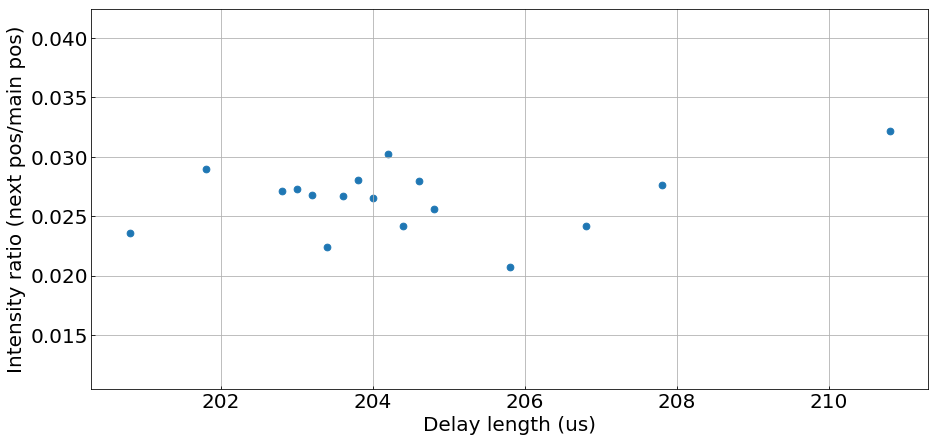

In [52]:
fig = plt.figure(figsize=(15,7))

plt.scatter(delay_list,ratio_list,s=45)
plt.tick_params(labelsize=20,direction='in')
plt.grid('on')
plt.ylabel('Intensity ratio (next pos/main pos)', fontsize=20)
plt.xlabel('Delay length (us)',fontsize=20)

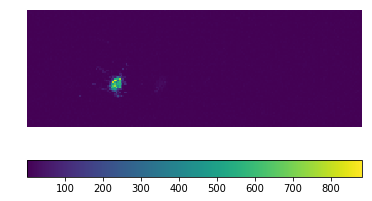

In [19]:
temp = np.load(path + 'S0_00015.npy')
temp[temp<0] = 1
plt.imshow(temp[100:170,200:400])
plt.axis('off')
plt.colorbar(orientation='horizontal')

In [84]:
np.asarray(center) + np.array([100,200])

array([116.14583333, 332.4375    ])

[252.72727273 144.04545455]


(-0.5, 199.5, 69.5, -0.5)

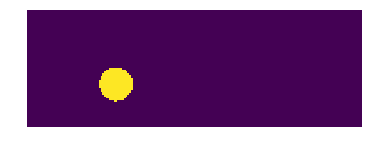

In [23]:
# Test mask generation on single frame
temp = np.load(path + 'S0_00015.npy')
mask = np.heaviside(temp-200,1)
plt.imshow(temp)
center = scipy.ndimage.measurements.center_of_mass(mask)
center = np.asarray(center)
print(center[::-1])
mask_beam = create_circular_mask(512,512,center=center[::-1], radius = 10)
plt.imshow(mask_beam[100:170,200:400] * temp[100:170,200:400])
plt.imshow(mask_beam[100:170,200:400])
plt.axis('off')

In [4]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask